In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import scipy
import keras
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list
from stochastic import random as strandom
from stochastic.processes.continuous import FractionalBrownianMotion

%load_ext autoreload
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-04-29 11:55:49.923439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 11:55:50.558023: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jwoo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-29 11:55:51.278570: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


2.16.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-29 11:55:51.357846: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 11:55:51.357901: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
SHUFFLE = True
MAX_EPOCHS = 10000
BATCH_SIZE = 1024
PATIENCE = 100
N = 10
T = 200
L = None

NB_INPUT_FEATURES = 1
SEARCH_WIDTH = 2
WINDOW_WIDTHS = [36, 48, 60, 72, 84]
SHIFT_WIDTH = 30
JUMP_D = 15

In [3]:
@tf.keras.utils.register_keras_serializable()
class Jaccard(tf.keras.Metric):
    def __init__(self, name='JSC', **kwargs):
        super().__init__(name=name, **kwargs)
        self.true_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_tp'
        )
        self.false_positives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fp'
        )
        self.false_negatives = self.add_variable(
            shape=(),
            initializer='zeros',
            name='JSC_fn'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.keras.ops.cast(y_true, "bool")
        y_pred = tf.keras.ops.cast(tf.math.round(y_pred), "bool")

        tp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, True))
        tp_values = tf.keras.ops.cast(tp_values, self.dtype)
        
        fp_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, True))
        fp_values = tf.keras.ops.cast(fp_values, self.dtype)
        
        fn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, True), tf.keras.ops.equal(y_pred, False))
        fn_values = tf.keras.ops.cast(fn_values, self.dtype)
        
        tn_values = tf.keras.ops.logical_and(
            tf.keras.ops.equal(y_true, False), tf.keras.ops.equal(y_pred, False))
        tn_values = tf.keras.ops.cast(tn_values, self.dtype)

        self.true_positives.assign(self.true_positives + tf.keras.ops.sum(tp_values))
        self.false_positives.assign(self.false_positives + tf.keras.ops.sum(fp_values))
        self.false_negatives.assign(self.false_negatives + tf.keras.ops.sum(fn_values))

    def result(self):
        return self.true_positives / (self.true_positives + self.false_positives + self.false_negatives)

In [4]:
classification_model = tf.keras.models.load_model('classification_model_0.keras')
#classification_model.summary()
regression_model = tf.keras.models.load_model('regression_model_0.keras')
#regression_model.summary()

TensorFlow version: 2.16.1


2024-04-29 11:55:55.334485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 11:55:55.334585: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 11:55:55.334617: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 11:55:55.435491: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-29 11:55:55.435547: I external/local_xla/xla/stream_executor

In [5]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list)

In [6]:
def make_signal(x_pos, y_pos, win_widths, search_width):
    all_vals = []
    for win_width in win_widths:
        if win_width > len(x_pos):
            continue
        vals = []
        for checkpoint in range(int(win_width/2), len(x_pos) - int(win_width/2)):
            xs = x_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]
            ys = y_pos[checkpoint - int(win_width/2) : checkpoint + int(win_width/2)]

            xs1 = xs[:int(len(xs)/2)] - float(xs[:int(len(xs)/2)][0])
            xs2 = xs[int(len(xs)/2):] - float(xs[int(len(xs)/2):][0])

            ys1 = ys[:int(len(ys)/2)] - float(ys[:int(len(ys)/2)][0])
            ys2 = ys[int(len(ys)/2):] - float(ys[int(len(ys)/2):][0])

            std_xs1 = np.std(xs1)
            std_xs2 = np.std(xs2)
            std_ys1 = np.std(ys1)
            std_ys2 = np.std(ys2)

            surface_xs1 = abs(np.sum(xs1)) / win_width
            surface_xs2 = abs(np.sum(xs2)) / win_width
            surface_ys1 = abs(np.sum(ys1)) / win_width
            surface_ys2 = abs(np.sum(ys2)) / win_width


            xs1 = np.cumsum(abs(xs1)) #* surface_xs1
            xs2 = np.cumsum(abs(xs2)) #* surface_xs2
            ys1 = np.cumsum(abs(ys1)) #* surface_ys1
            ys2 = np.cumsum(abs(ys2)) #* surface_ys2


            xs_max_val = max(np.max(abs(xs1)), np.max(abs(xs2)))
            xs1 = xs1 / xs_max_val
            xs2 = xs2 / xs_max_val
            xs1 = xs1 / win_width
            xs2 = xs2 / win_width

            ys_max_val = max(np.max(abs(ys1)), np.max(abs(ys2)))
            ys1 = ys1 / ys_max_val
            ys2 = ys2 / ys_max_val
            ys1 = ys1 / win_width 
            ys2 = ys2 / win_width

            vals.append(abs(np.sum(xs1 - xs2 + ys1 - ys2)) 
                       * (max(std_xs1, std_xs2) / min(std_xs1, std_xs2)) 
                             * (max(std_ys1, std_ys2) / min(std_ys1, std_ys2)))

        vals = np.concatenate((np.zeros(int(win_width/2)), vals))
        vals = np.concatenate((vals, np.zeros(int(win_width/2))))
        vals = np.array(vals)
        all_vals.append(vals)
    
    all_vals = np.array(all_vals) + 1e-5
    normalized_vals = all_vals.copy()
    for i in range(len(normalized_vals)):
            normalized_vals[i] = normalized_vals[i] / np.max(normalized_vals[i])
    return np.vstack((all_vals, normalized_vals))

In [7]:
def slice_data(signal_seq, jump_d=15):
    slice_d = []
    indice = []
    std_signal = np.std(signal_seq, axis=1).reshape(-1, 1)
    mean_signal = np.mean(signal_seq, axis=1).reshape(-1, 1)
    for i in range(SHIFT_WIDTH//2, signal_seq.shape[1] - SHIFT_WIDTH//2, jump_d):
        crop = signal_seq[:, i - SHIFT_WIDTH//2: i + SHIFT_WIDTH//2]
        crop = np.hstack((crop, mean_signal))
        crop = np.hstack((crop, std_signal))
        slice_d.append(crop)
        indice.append(i)
    return np.array(slice_d), np.array(indice)

In [8]:
def merge_close_points(changepoints, signals, seuil=5):
    seq_sums = []
    for i in range(len(signals)):
        tmp = []
        for j in range(len(signals[i])):
            if j < SEARCH_WIDTH:
                tmp.append(signals[i][j] * ((SEARCH_WIDTH * 2) + 1))
            elif j > len(signals[i]) - 1 - SEARCH_WIDTH:
                tmp.append(signals[i][j] * ((SEARCH_WIDTH * 2) + 1))
            else:
                tmp.append(np.sum(signals[i][j-SEARCH_WIDTH:j+SEARCH_WIDTH+1]))
        tmp = np.array(tmp)
        seq_sums.append(tmp)
    seq_sums = np.array(seq_sums)
    seq_sums = np.sum(seq_sums, axis=0)
    val_orders = np.argsort(seq_sums[changepoints])[::-1]
    
    filtered_cps = []
    all_cps_range = set()
    for cp in changepoints[val_orders]:
        regis_cp_range = np.arange(-seuil + cp, seuil + cp)
        if len(set(regis_cp_range) & all_cps_range) == 0:
            filtered_cps.append(cp)
            all_cps_range.update(regis_cp_range)
    filtered_cps = np.array(filtered_cps)
    return filtered_cps

In [9]:
def ana_cp_predict(x, y, win_widths, search_width, jump_d):
    signal_seq = make_signal(x, y, win_widths, search_width)
    predict_input, indice = slice_data(signal_seq, jump_d=jump_d)
    activ_nb_win = np.sum(np.array(win_widths) <= np.array([len(x)] * len(win_widths)))
    if activ_nb_win > 0:
        predict_input = np.array(predict_input).reshape(-1, activ_nb_win*2, SHIFT_WIDTH+2, 1)
        pred = classification_model.predict(predict_input, verbose=0).flatten()
        cps = indice[np.round(pred) >= 1]
        if len(cps) == 0:
            return []
        reg_inputs = []
        for cp in cps:
            reg_inputs.append(signal_seq[:, cp - (SHIFT_WIDTH//2): cp + (SHIFT_WIDTH//2)])
        reg_inputs = np.array(reg_inputs).reshape(-1, activ_nb_win*2, SHIFT_WIDTH, 1)
        reg_outputs = regression_model.predict(reg_inputs, verbose=0).flatten()
        cps = np.round(cps + reg_outputs).astype(int)
        cps = merge_close_points(cps, signal_seq)
        return cps
    else:
        return []

# Produce results

In [10]:
import os
public_data_path = 'public_data/' # make sure the folder has this name or change it
path_results = 'res/'
if not os.path.exists(path_results):
    os.makedirs(path_results)

In [11]:
from andi_datasets.utils_videos import import_tiff_video
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

video = import_tiff_video(public_data_path+'track_1/exp_0/videos_fov_1.tiff')

/home/jwoo/SPT_a/andi_datasets/utils_videos.py:22: UserWarning: From your imports it seems that you will need Deeptrack. Install if needed using pip install deeptrack.
  warnings.warn('From your imports it seems that you will need Deeptrack. Install if needed using pip install deeptrack.')


[ 16  18  19  20  21  22  24  27  28  29 255]


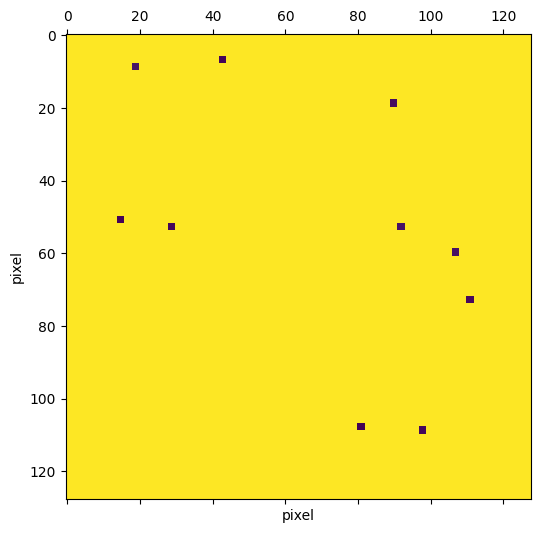

In [13]:
print(np.unique(video[0]))
plt.matshow(video[0])
plt.xlabel('pixel');plt.ylabel('pixel');

In [17]:
for track in [1,2]:
    
    # Create the folder of the track if it does not exists
    path_track = path_results + f'track_{track}/'
    if not os.path.exists(path_track):
        os.makedirs(path_track)
        
    for exp in range(10):
        # Create the folder of the experiment if it does not exits
        path_exp = path_track+f'exp_{exp}/'
        if not os.path.exists(path_exp):
            os.makedirs(path_exp)
        file_name = path_exp + 'ensemble_labels.txt'
        
        with open(file_name, 'a') as f:
            # Save the model (random) and the number of states (2 in this case)
            model_name = np.random.choice(datasets_phenom().avail_models_name, size = 1)[0]
            f.write(f'model: {model_name}; num_state: {2} \n')

            # Create some dummy data for 2 states. This means 2 columns
            # and 5 rows
            data = np.random.rand(5, 2)
            
            data[-1,:] /= data[-1,:].sum()

            # Save the data in the corresponding ensemble file
            np.savetxt(f, data, delimiter = ';')

In [24]:
# Define the number of experiments and number of FOVS
N_EXP = 10 
N_FOVS = 30

# The results go in the same folders generated above
path_results = 'res/'

for track in [1, 2]:
    path_track = path_results + f'track_{track}/'
    for exp in range(N_EXP):
        path_exp = path_track + f'exp_{exp}/'
        for fov in range(N_FOVS):
            # We read the corresponding csv file from the public data and extract the indices of the trajectories:
            if track == 2:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
            else:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
            traj_idx = df.traj_idx.unique()
            submission_file = path_exp + f'fov_{fov}.txt'

            with open(submission_file, 'w') as f:

                # Loop over each index
                for idx in traj_idx:

                    # Get the lenght of the trajectory
                    x = np.array(df[df.traj_idx == idx])[:, 2]
                    y = np.array(df[df.traj_idx == idx])[:, 3]
                    length_traj = df[df.traj_idx == idx].shape[0]

                    # Assign one changepoints for each traj at 0.25 of its length
                    cps = ana_cp_predict(x, y, WINDOW_WIDTHS, SEARCH_WIDTH, JUMP_D)
                    cps = np.concatenate((cps, [length_traj])).astype(int)

                    prediction_traj = [idx.astype(int)]
                    for k, alpha, state, cp in zip([99999999] * len(cps), [99999999] * len(cps),
                                                   [99999999] * len(cps), cps):
                        prediction_traj.append(k)
                        prediction_traj.append(alpha)
                        prediction_traj.append(state)
                        prediction_traj.append(cp)

                    formatted_numbers = ','.join(map(str, prediction_traj))
                    f.write(formatted_numbers + '\n')


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3

In [ ]:
for track in [1, 2]:
    path_track = path_results + f'track_{track}/'

    for exp in range(N_EXP):

        path_exp = path_track + f'exp_{exp}/'

        for fov in range(N_FOVS):
            
            # We read the corresponding csv file from the public data and extract the indices of the trajectories:
            if track == 2:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/trajs_fov_{fov}.csv')
            else:
                df = pd.read_csv(public_data_path + f'track_{track}/exp_{exp}/videos_fov_{fov}_track.csv')
            traj_idx = df.traj_idx.unique()
            submission_file = path_exp + f'fov_{fov}.txt'

            with open(submission_file, 'w') as f:

                # Loop over each index
                for idx in traj_idx:

                    # Get the lenght of the trajectory
                    x = np.array(df[df.traj_idx == idx])[:, 2]
                    y = np.array(df[df.traj_idx == idx])[:, 3]
                    length_traj = df[df.traj_idx == idx].shape[0]

                    # Assign one changepoints for each traj at 0.25 of its length
                    cps = ana_cp_predict(x, y, WINDOW_WIDTHS, SEARCH_WIDTH, JUMP_D)
                    cps = np.concatenate((cps, [length_traj])).astype(int)

                    prediction_traj = [idx.astype(int)]
                    for k, alpha, state, cp in zip([99999999] * len(cps), [99999999] * len(cps),
                                                   [99999999] * len(cps), cps):
                        prediction_traj.append(k)
                        prediction_traj.append(alpha)
                        prediction_traj.append(state)
                        prediction_traj.append(cp)

                    formatted_numbers = ','.join(map(str, prediction_traj))
                    f.write(formatted_numbers + '\n')
